# Visualizing GEDI_L2A Dataset in R

Authors: Harshini Girish (UAH), Sheyenne Kirkland (UAH), Alex Mandel (Development Seed), Chuck Daniels (Development Seed)

Date: 2 September, 2025

Description: This notebook reads a GEDI dataset stored in Geoparquet format and converts it into a spatial `sf` object using its geometry column. A bounding box is defined using geographic coordinates to extract a spatial subset of the data. Points falling within this bounding area are filtered using `st_intersects()` and stored for analysis. Key attributes such as elevation and sensitivity are extracted and combined with geographic coordinates to create a clean display-ready DataFrame. Finally, the filtered points and bounding box are visualized on an interactive Leaflet map, enabling geographic inspection of shot-level GEDI metrics.


## Run This Notebook

To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors. Users should work within the "R/Python" workspace.

## Additional Resources
 
- [GEDI L2A Product Documentation](https://docs.maap-project.org/en/troubleshooting-section/science/GEDI/GEDI_L2A.html): A science-focused overview of the GEDI L2A product structure, measurement principles, and available variables, including footprint-level elevation, sensitivity, and quality flags.

- [Accessing GEDI Data in R](https://docs.maap-project.org/en/troubleshooting-section/technical_tutorials/working_with_r/gedi_access_r.html): Step-by-step tutorial for accessing and loading GEDI HDF5 or GeoParquet files into R using packages like `arrow`, `sf`, and `rhdf5`, with examples tailored for the MAAP ADE.

- [Submitting R Jobs in MAAP](https://docs.maap-project.org/en/troubleshooting-section/technical_tutorials/working_with_r/submitting_jobs_r.html): A tutorial that demonstrates how to submit R scripts as batch jobs within the MAAP Algorithm Development Environment (ADE), including workspace setup and job status tracking.

- [GEDI_L4A Subset and Visualize](https://docs.maap-project.org/en/latest/science/GEDI/GEDI_L4A.html): This tutorial, will use a GeoJSON to create an area of interest (AOI) and use it in MAAP’s GEDI Subsetter followed by visualizing the output file created by the subsetter by plotting elevation contours.


## Install/Import Libraries
Let’s install and load the packages necessary for this tutorial.

In [48]:
library(arrow)
library(sf)
library(dplyr)
library(leaflet)
library(tmap)
library(rnaturalearth)
data(World)
library(terra)


## Load the dataset

This line reads a Parquet file from the MAAP shared path into a DataFrame `df`.
The data is converted into an `sf` object with a `CRS(EPSG:4326)`. This enables spatial operations and interactive mapping.

In [18]:
df <- read_parquet("/projects/shared-buckets/harshinigirish/gedi_subset.parquet")
df_sf <- st_as_sf(df, crs = 4326)  


## Preview the Data

We can now inspect columns such as beam ID, elevation, AGBD, and sensitivity values.


In [19]:
colnames(df)


[1] "filename"                   "agbd"                      
[3] "agbd_se"                    "sensitivity"               
[5] "geolocation/sensitivity_a2" "elev_lowestmode"           
[7] "geometry"

## Leaflet-Based Visualization

This step creates an interactive Leaflet map to visualize shot locations from the `df_sf` dataset. Each point is plotted as a circle using its longitude and latitude, with a popup label showing the shot number. The map uses OpenStreetMap tiles and is centered on the mean coordinates of all points. A zoom level of 13 ensures a detailed local view. 

In [20]:
center <- st_coordinates(st_centroid(st_union(df_sf)))

leaflet(df_sf) %>%
  addProviderTiles("OpenStreetMap") %>%
  addCircleMarkers(
    radius = 4,
    popup = ~paste("AGBD:", agbd, "<br>Sensitivity:", `geolocation/sensitivity_a2`)
  ) %>%
  setView(
    lng = center[1],
    lat = center[2],
    zoom = 13
  )


HTML widgets cannot be represented in plain text (need html)

## Spatial Filtering and Visualization Using a Bounding Box


A bounding box is defined using specific longitude and latitude limits to focus on a smaller spatial region. Points from the dataset are filtered to include only those within this bounding box using `st_intersects()`.The resulting points and the bounding box are visualized together on an interactive Leaflet map.


In [21]:
# Define bounding box and convert to polygon
box <- st_bbox(c(
  xmin = 85.4, xmax = 85.9,
  ymin = 28.0, ymax = 28.3
), crs = st_crs(4326))

bounds_poly <- st_as_sfc(box)
st_crs(bounds_poly) <- st_crs(df_sf)

# Filter using spatial intersection
df_filtered <- df_sf[
  st_intersects(df_sf, bounds_poly, sparse = FALSE)[, 1],
]

# Confirm subset
nrow(df_filtered)


[1] 247

In [22]:
pal <- colorNumeric("YlGnBu", domain = df_filtered$agbd, na.color = "gray")


center <- st_coordinates(st_centroid(st_union(df_filtered)))


leaflet(df_filtered) %>%
  addProviderTiles("OpenStreetMap") %>%
  addPolygons(data = bounds_poly, color = "red", weight = 2, fill = FALSE) %>%
  addCircleMarkers(
    radius = 4,
    color = ~pal(agbd),
    stroke = FALSE,
    fillOpacity = 0.8,
    popup = ~paste0(
      "Shot: ", seq_len(nrow(df_filtered)), "<br>",
      "AGBD: ", round(agbd, 2), "<br>",
      "Elevation: ", round(elev_lowestmode, 2), " m<br>",
      "Sensitivity A2: ", round(`geolocation/sensitivity_a2`, 3)
    )
  ) %>%
  addLegend("bottomright", pal = pal, values = ~agbd, title = "AGBD") %>%
  setView(lng = center[1], lat = center[2], zoom = 10)


HTML widgets cannot be represented in plain text (need html)

## Elevation-Based Map Visualization

This Leaflet map visualizes GEDI shot locations using a color-coded scheme based on elevation values (`elev_lowestmode`). A continuous `viridis` color palette is generated with `colorNumeric()` and applied to the circle markers. Each point displays a popup with the shot number and rounded elevation. The map view is centered using the centroid of all spatial features in the dataset to ensure optimal framing.


In [23]:
elev_pal <- colorNumeric(
  palette = "viridis",
  domain = df_sf$elev_lowestmode,
  na.color = "gray"
)

df_sf$Shot.Number <- seq_len(nrow(df_sf))

# Build leaflet map
leaflet(df_sf) %>%
  addProviderTiles("OpenStreetMap") %>%
  addCircles(
    radius = 40,
    color = ~elev_pal(elev_lowestmode),
    popup = ~paste(
      "Shot Number:", Shot.Number, "<br>",
      "Elevation:", round(elev_lowestmode, 2), "m"
    )
  ) %>%
  addLegend(
    position = "bottomright",
    pal = elev_pal,
    values = ~elev_lowestmode,
    title = "Elevation (m)"
  ) %>%
  setView(
    lng = center[1],
    lat = center[2],
    zoom = 12
  )


HTML widgets cannot be represented in plain text (need html)

## Static Plot using plot()

This example creates a quick static map of GEDI data using base R plotting. It aligns the dataset and basemap to the same CRS, calculates and expands the data’s bounding box for padding, and crops the basemap for faster rendering. This lightweight approach is ideal for rapid spatial overviews without complex styling or heavy dependencies.






Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


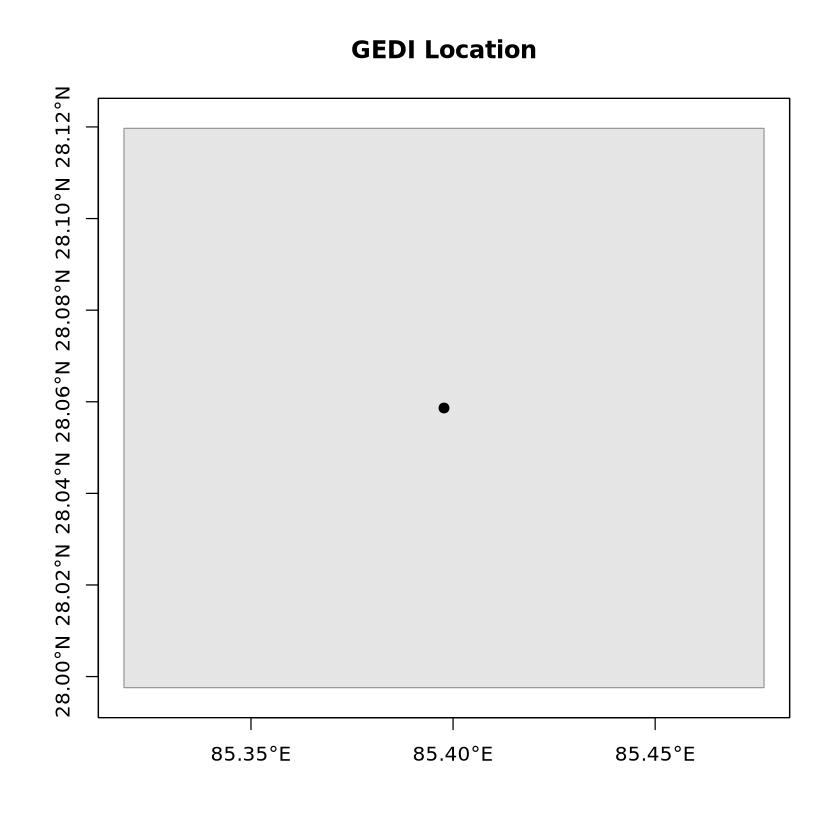

In [34]:
crs <- sf::st_crs(df_sf)
if (is.na(crs)) {
  df_sf <- sf::st_set_crs(df_sf, 4326)
  crs <- sf::st_crs(df_sf)
}
if (!identical(sf::st_crs(World), crs)) {
  World <- sf::st_transform(World, crs)  
}

bb <- sf::st_bbox(df_sf)
dx <- (bb$xmax - bb$xmin) * 0.25
dy <- (bb$ymax - bb$ymin) * 0.25
bb_exp <- structure(
  c(xmin = bb$xmin - dx,
    ymin = bb$ymin - dy,
    xmax = bb$xmax + dx,
    ymax = bb$ymax + dy),
  class = class(bb),
  crs   = crs
)


world_reg <- sf::st_crop(World, bb_exp)

center <- c((bb["xmin"] + bb["xmax"])/2, (bb["ymin"] + bb["ymax"])/2)
center_sf <- sf::st_sfc(sf::st_point(center), crs = crs)

#Plot
plot(sf::st_geometry(world_reg), col = "grey90", border = "grey60",
     axes = TRUE, main = "GEDI Location")
plot(center_sf, add = TRUE, pch = 20, cex = 1.6)
box()


## Static GEDI Map using tmap()

This example uses tmap in static mode to overlay GEDI footprint points on a Natural Earth color shaded-relief basemap `(HYP_50M_SR)`. The workflow: download the raster, compute the data extent with `st_bbox(df_sf)`, enlarge it by a configurable padding factor (pad) to provide contextual margins, and crop the global raster to that expanded window with terra for faster rendering. Both layers are kept in the same CRS, the cropped RGB raster is drawn with `tm_rgb(r=3, g=2, b=1)`, and the GEDI points are plotted on top. This yields a clear, focused map while avoiding full-world rendering and keeping styling simple.

tmap mode set to plotting



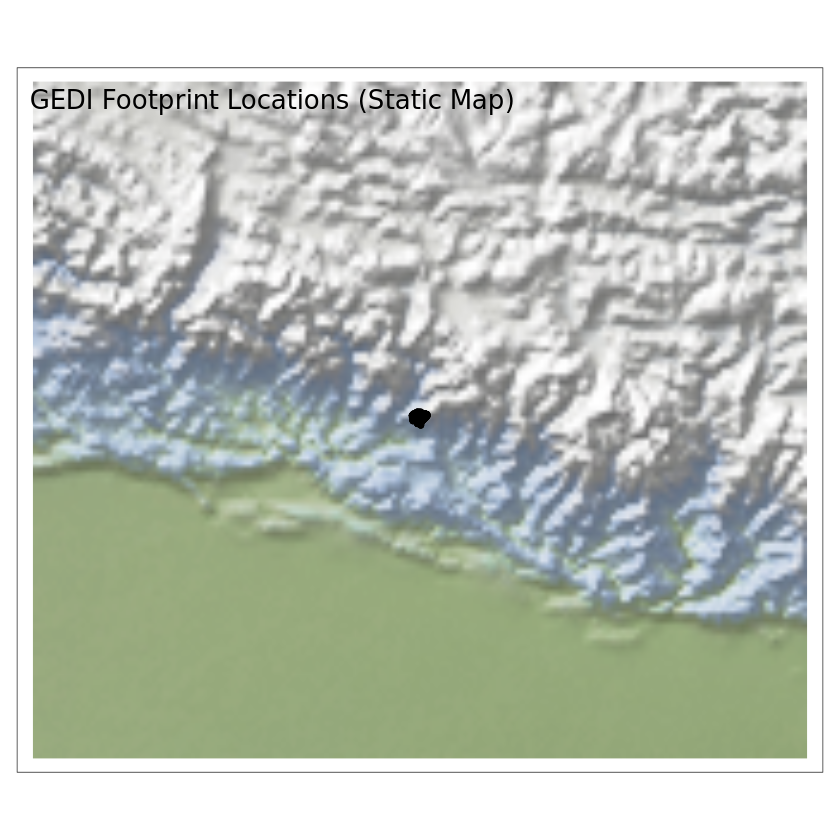

In [36]:
shaded_relief <- rnaturalearth::ne_download(
  scale=50, 
  type="HYP_50M_SR", 
  category="raster"
)


bb  <- st_bbox(df_sf)
pad <- 25
dx <- (bb["xmax"] - bb["xmin"]) * pad
dy <- (bb["ymax"] - bb["ymin"]) * pad
bb_exp <- structure(
  c(xmin = bb["xmin"] - dx, ymin = bb["ymin"] - dy,
    xmax = bb["xmax"] + dx, ymax = bb["ymax"] + dy),
  class = class(bb), crs = st_crs(df_sf)
)

shaded_relief_crop <- terra::crop(shaded_relief, bb_exp)

tmap_mode("plot")

tmap::tm_shape(shaded_relief_crop) +
    tmap::tm_rgb(r=3, g=2, b=1) + 
tm_shape(df_sf) +  
    tm_dots(size = 0.1) +
    tm_layout(
    title = "GEDI Footprint Locations (Static Map)",
    
  )